# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('datasets/Churn.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [3]:
data['Tenure'] = data['Tenure'].fillna(0)
data = data.drop(['RowNumber','CustomerId','Surname'], axis=1)
data.duplicated().sum()

0

In [4]:
data = pd.get_dummies(data, drop_first=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  float64
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  uint8  
 10  Geography_Spain    10000 non-null  uint8  
 11  Gender_Male        10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


**Вывод**

Ознакомились с данными, убрали нулевые значения и ненужные столбцы, защитились от дамми-ловушек. Дубликатов не обнаружили

## Исследование задачи

Разбиваем данные на 60/20/20

In [5]:
target = data['Exited']
features = data.drop('Exited', axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, random_state=1337228)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=1337228)

Посмотрим дисбаланс

In [6]:
target.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

А он у нас 1 к 4

### Модели

#### Решающее дерево

In [7]:
best_depth = 0
best_f1 = 0
for depth in range(2, 20):
    model = DecisionTreeClassifier(random_state=1337228, max_depth=depth)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_depth = depth
        best_f1 = f1
print('Лучшее значение F1', best_f1,'на глубине', best_depth)

Лучшее значение F1 0.5773809523809524 на глубине 7


#### Случайный лес

In [8]:
best_est = 0
best_f1 = 0
for estimator in range(30, 60, 1):
    model =  RandomForestClassifier(random_state=1337228, n_estimators=estimator)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_est = estimator
        best_f1 = f1
print('Лучшее значение F1', best_f1,'при количестве деревьев', best_est)

Лучшее значение F1 0.5803432137285491 при количестве деревьев 49


#### Логистическая регрессия

In [9]:
best_max_iter = 0
best_f1 = 0

for max_iter in range(1,100):
    model = LogisticRegression(random_state=1337228, max_iter=max_iter)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_max_iter = max_iter
        best_f1 = f1
print('Лучшее значение F1', best_f1,'при количестве итераций', best_max_iter)

Лучшее значение F1 0.1475409836065574 при количестве итераций 44


### Accuracy, precision, recall, f1

In [10]:
model = DecisionTreeClassifier(random_state=1337228, max_depth=7)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Решающее дерево')
print('Accuracy', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model = RandomForestClassifier(random_state=1337228, n_estimators=49)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Случайный лес')
print('Accuracy', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model = LogisticRegression(random_state=1337228, max_iter=44, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Логистическая регрессия')
print('Accuracy', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

Решающее дерево
Accuracy 0.858
Precision 0.7028985507246377
Recall 0.4898989898989899
F1 0.5773809523809524

Случайный лес
Accuracy 0.8655
Precision 0.7591836734693878
Recall 0.4696969696969697
F1 0.5803432137285491

Логистическая регрессия
Accuracy 0.7945
Precision 0.39436619718309857
Recall 0.0707070707070707
F1 0.11991434689507494



### ROC-кривая и AUC-ROC

AUC-ROC DecisionTreeClassifier 0.8270973450212852
AUC-ROC RandomForestClassifier 0.8446583981964282
AUC-ROC LogisticRegression 0.6571953953500088


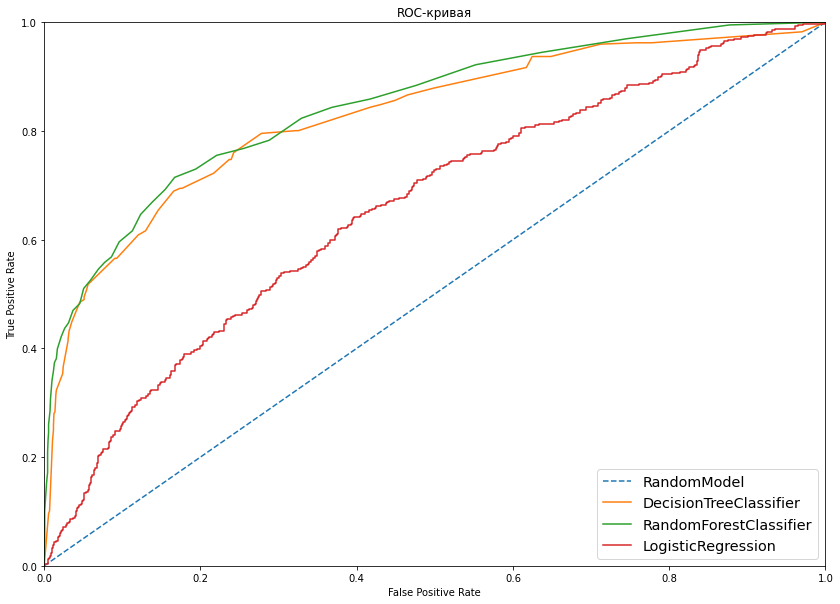

In [11]:
plt.figure(figsize=[14,10])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')

model = DecisionTreeClassifier(random_state=1337228, max_depth=7)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC DecisionTreeClassifier',auc_roc)
plt.plot(fpr, tpr, label='DecisionTreeClassifier')

model = RandomForestClassifier(random_state=1337228, n_estimators=49)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC RandomForestClassifier',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier')

model = LogisticRegression(random_state=1337228, max_iter=44, solver='liblinear')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC LogisticRegression',auc_roc)
plt.plot(fpr, tpr, label='LogisticRegression')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

**Вывод:**

По полученным результатам можно заметить, что метрика F1 и AUC-ROC лучшая на случаном лесе.

## Борьба с дисбалансом

### Взвешивание классов

In [12]:
model = DecisionTreeClassifier(random_state=1337228, max_depth=7, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Решающее дерево')
print('Accuracy', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model = RandomForestClassifier(random_state=1337228, n_estimators=49, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Случайный лес')
print('Accuracy', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model = LogisticRegression(random_state=1337228, max_iter=44, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Логистическая регрессия')
print('Accuracy', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

Решающее дерево
Accuracy 0.7785
Precision 0.46102819237147596
Recall 0.702020202020202
F1 0.5565565565565566

Случайный лес
Accuracy 0.864
Precision 0.7605042016806722
Recall 0.45707070707070707
F1 0.5709779179810724

Логистическая регрессия
Accuracy 0.677
Precision 0.33509234828496043
Recall 0.6414141414141414
F1 0.440207972270364



### Увеличение выборки

In [13]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [14]:
model = DecisionTreeClassifier(random_state=1337228, max_depth=7)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print('Решающее дерево')
print('Accuracy', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model = RandomForestClassifier(random_state=1337228, n_estimators=49)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print('Случайный лес')
print('Accuracy', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model = LogisticRegression(random_state=1337228, max_iter=44, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print('Логистическая регрессия')
print('Accuracy', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

Решающее дерево
Accuracy 0.778
Precision 0.4601328903654485
Recall 0.6994949494949495
F1 0.5551102204408818

Случайный лес
Accuracy 0.855
Precision 0.653179190751445
Recall 0.5707070707070707
F1 0.6091644204851752

Логистическая регрессия
Accuracy 0.6485
Precision 0.31303288672350793
Recall 0.648989898989899
F1 0.42235004108463436



### Уменьшение выборки

In [15]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=1337228)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=1337228)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=1337228)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

In [16]:
model = DecisionTreeClassifier(random_state=1337228, max_depth=7)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print('Решающее дерево')
print('Accuracy', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model = RandomForestClassifier(random_state=1337228, n_estimators=49)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print('Случайный лес')
print('Accuracy', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model = LogisticRegression(random_state=1337228,max_iter=44, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print('Логистическая регрессия')
print('Accuracy', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

Решающее дерево
Accuracy 0.7445
Precision 0.4155653450807636
Recall 0.7146464646464646
F1 0.5255338904363974

Случайный лес
Accuracy 0.7705
Precision 0.4510108864696734
Recall 0.7323232323232324
F1 0.5582290664100096

Логистическая регрессия
Accuracy 0.65
Precision 0.3141809290953545
Recall 0.648989898989899
F1 0.4233937397034596



Лучшей моделью по значению F-меры стал случайный лес с увеличением выборки. Выведем ROC-кривую и AUC-ROC 

AUC-ROC DecisionTreeClassifier 0.8105076639210056
AUC-ROC RandomForestClassifier 0.8447087772991763
AUC-ROC LogisticRegression 0.6939264842943147


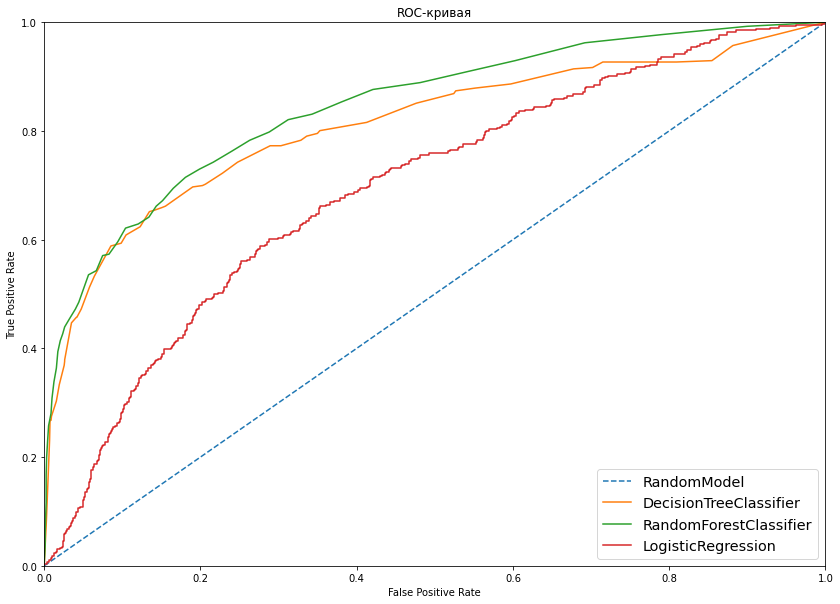

In [17]:
plt.figure(figsize=[14,10])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


model = DecisionTreeClassifier(random_state=1337228, max_depth=7)
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC DecisionTreeClassifier',auc_roc)
plt.plot(fpr, tpr, label='DecisionTreeClassifier')

model = RandomForestClassifier(random_state=1337228, n_estimators=49)
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC RandomForestClassifier',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier')

model = LogisticRegression(random_state=1337228, max_iter = 44, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC LogisticRegression',auc_roc)
plt.plot(fpr, tpr, label='LogisticRegression')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

## Тестирование модели

На тестовой выборке применим модель случайного леса с увеличением выборке и поэкспериментируем с гиперпараметрами для увеличения F-меры

Сначала попробуем увеличить диапозон поиска лучшего значения n_estimators, а после изучим энтропийный и джини критерии

In [18]:
best_est = 0
best_f1 = 0
for estimator in range(10, 400, 10):
    model =  RandomForestClassifier(random_state=1337228, n_estimators=estimator)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_est = estimator
        best_f1 = f1
print('Лучшее значение F1', best_f1,'при количестве деревьев', best_est)

Лучшее значение F1 0.6117969821673525 при количестве деревьев 150


In [19]:
model =  RandomForestClassifier(random_state=1337228, n_estimators=150,criterion='gini')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
f1 = f1_score(target_valid, predicted_valid)
print('Количество деревьев: 150')
print('F1', f1)   

Количество деревьев: 150
F1 0.6117969821673525


In [20]:
model =  RandomForestClassifier(random_state=1337228, n_estimators=150,criterion='entropy')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
f1 = f1_score(target_valid, predicted_valid)
print('Количество деревьев: 150')
print('F1', f1)   

Количество деревьев: 150
F1 0.5956284153005464


Критерий gini дает лучшее значение F1, которое превышает 0.59, что и нужно для решения задачи. Однако на тестовой выборке значение может уменшиться. Рассмотрим еще гиперпараметры min_samples_split и min_samples_leaf

In [21]:
for samples_split in range(2, 10):
    model =  RandomForestClassifier(random_state=1337228, n_estimators=150, 
                                    min_samples_split=samples_split,criterion='gini')
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    print('Samples_split', samples_split,'F1', f1_score(target_valid, predicted_valid))

Samples_split 2 F1 0.6117969821673525
Samples_split 3 F1 0.5800273597811217
Samples_split 4 F1 0.5932885906040268
Samples_split 5 F1 0.5820105820105821
Samples_split 6 F1 0.5928853754940713
Samples_split 7 F1 0.5883870967741937
Samples_split 8 F1 0.5889884763124199
Samples_split 9 F1 0.5861182519280206


In [22]:
for samples_leaf in range(2, 10):
    model =  RandomForestClassifier(random_state=1337228, n_estimators=150, min_samples_split=2,
                                   min_samples_leaf = samples_leaf,criterion='gini')
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    print('Samples_leaf', samples_leaf,'F1', f1_score(target_valid, predicted_valid))

Samples_leaf 2 F1 0.5905006418485237
Samples_leaf 3 F1 0.6002460024600246
Samples_leaf 4 F1 0.6030989272943981
Samples_leaf 5 F1 0.5976470588235293
Samples_leaf 6 F1 0.6045977011494252
Samples_leaf 7 F1 0.593010146561443
Samples_leaf 8 F1 0.6015712682379349
Samples_leaf 9 F1 0.6049107142857143


Теперь, когда получена лучшая модель, можно применить её к тестовой выборке
- с дисбалансом
- с взвешенными классами
- с увелечением выборки
- с уменьшением выборки

In [23]:
model = RandomForestClassifier(random_state=1337228, n_estimators=150, min_samples_split=2,
                                   min_samples_leaf = 9,criterion='gini')
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
print('Случайный лес - дисбаланс классов')
print('Accuracy', accuracy_score(target_test, predicted_test))
print('Precision', precision_score(target_test, predicted_test))
print('Recall', recall_score(target_test, predicted_test))
print('F1', f1_score(target_test, predicted_test))
print()

model = RandomForestClassifier(random_state=1337228, n_estimators=150, min_samples_split=2,
                                   min_samples_leaf = 9,criterion='gini')
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
print('Случайный лес - взвешенные классы')
print('Accuracy', accuracy_score(target_test, predicted_test))
print('Precision', precision_score(target_test, predicted_test))
print('Recall', recall_score(target_test, predicted_test))
print('F1', f1_score(target_test, predicted_test))
print()

model = RandomForestClassifier(random_state=1337228, n_estimators=150, min_samples_split=2,
                                   min_samples_leaf = 9,criterion='gini')
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)
print('Случайный лес - увеличеие выборки')
print('Accuracy', accuracy_score(target_test, predicted_test))
print('Precision', precision_score(target_test, predicted_test))
print('Recall', recall_score(target_test, predicted_test))
print('F1', f1_score(target_test, predicted_test))
print()

model = RandomForestClassifier(random_state=1337228, n_estimators=150, min_samples_split=2,
                                   min_samples_leaf = 9,criterion='gini')
model.fit(features_downsampled, target_downsampled)
predicted_test = model.predict(features_test)
print('Случайный лес - уменьшение выборки')
print('Accuracy', accuracy_score(target_test, predicted_test))
print('Precision', precision_score(target_test, predicted_test))
print('Recall', recall_score(target_test, predicted_test))
print('F1', f1_score(target_test, predicted_test))
print()

Случайный лес - дисбаланс классов
Accuracy 0.862
Precision 0.8232558139534883
Recall 0.42650602409638555
F1 0.5619047619047619

Случайный лес - взвешенные классы
Accuracy 0.862
Precision 0.8232558139534883
Recall 0.42650602409638555
F1 0.5619047619047619

Случайный лес - увеличеие выборки
Accuracy 0.821
Precision 0.5564356435643565
Recall 0.6771084337349398
F1 0.6108695652173913

Случайный лес - уменьшение выборки
Accuracy 0.7795
Precision 0.4796875
Recall 0.7397590361445783
F1 0.5819905213270142



AUC-ROC RandomForestClassifier - disbalanced 0.8527292767283645
AUC-ROC RandomForestClassifier - balanced by class weight 0.8527292767283645
AUC-ROC RandomForestClassifier - balanced by reduce 0 class 0.8471939492987723
AUC-ROC RandomForestClassifier - balanced by grow 1 class 0.8540549580023564


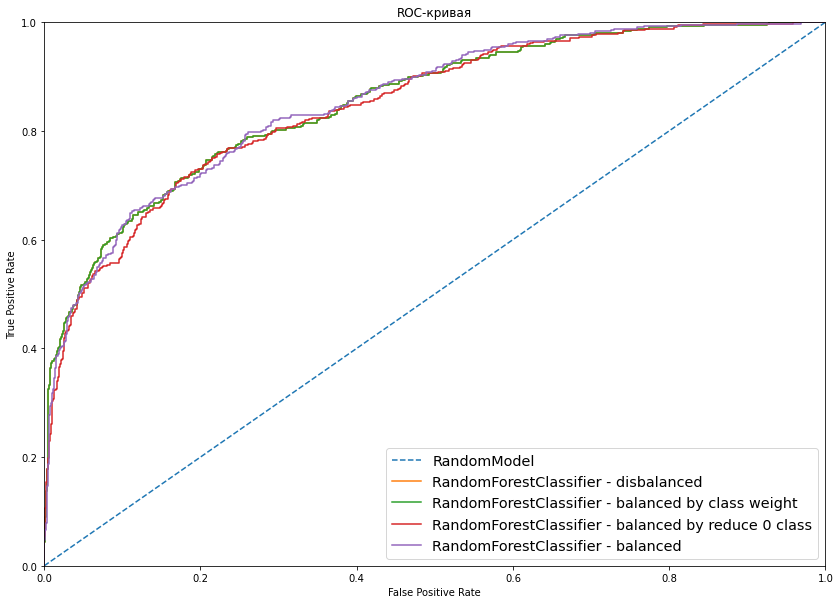

In [24]:
plt.figure(figsize=[14,10])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


model = RandomForestClassifier(random_state=1337228, n_estimators=150, min_samples_split=2,
                                   min_samples_leaf = 9,criterion='gini')
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC RandomForestClassifier - disbalanced',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier - disbalanced')

model = RandomForestClassifier(random_state=1337228, n_estimators=150, min_samples_split=2,
                                   min_samples_leaf = 9,criterion='gini')
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC RandomForestClassifier - balanced by class weight',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier - balanced by class weight')

model = RandomForestClassifier(random_state=1337228, n_estimators=150, min_samples_split=2,
                                   min_samples_leaf = 9,criterion='gini')
model.fit(features_downsampled, target_downsampled)
predicted_test = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC RandomForestClassifier - balanced by reduce 0 class',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier - balanced by reduce 0 class')

model = RandomForestClassifier(random_state=1337228, n_estimators=150, min_samples_split=2,
                                   min_samples_leaf = 9,criterion='gini')
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC RandomForestClassifier - balanced by grow 1 class',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier - balanced')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

**Всего одна модель превысила заданную в условии F1-меру и это модель случайного леса с увеличеием выборки**